In [2]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 

In [3]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

In [4]:
data = pd.read_csv('20_newsgroup.csv', index_col = 0)
# Select only 5 classes
class_mask = data["target"].isin([7,9,13,18,19])
data = data[class_mask]
data.head()

,text,target,title,date
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,2022-04-04 16:49:47.367191
10,the blood of the lamb.\n\nThis will be a hard ...,19,talk.religion.misc,2022-04-04 16:49:47.367191
12,930418\n\nDo what thou wilt shall be the whole...,19,talk.religion.misc,2022-04-04 16:49:47.367191
40,\n\nNo. Zeno's paradox is resolved by showing...,19,talk.religion.misc,2022-04-04 16:49:47.367191
58,"\nDefinitely, J.R. ""Bob"" Dobbs, numero uno, to...",19,talk.religion.misc,2022-04-04 16:49:47.367191


In [5]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
df_train, df_test = train_test_split(data,test_size=0.2,shuffle=True)

In [6]:
! pip install seaborn

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

9     803
7     799
13    780
18    613
19    506
Name: target, dtype: int64


C:\Users\javij\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

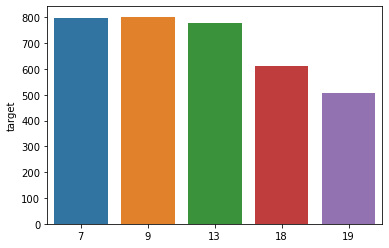

In [8]:
x=df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [9]:
df_train.isna().sum()

text      102
target      0
title       0
date        0
dtype: int64

In [10]:
# WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['word_count'].mean()) #Non-Disaster tweets

nan
nan


In [11]:
df_train = df_train.dropna()

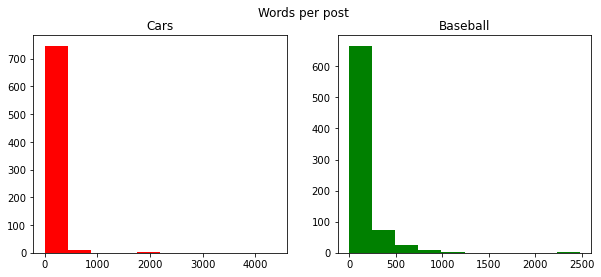

In [12]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==7]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Cars')
train_words=df_train[df_train['target']==9]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Baseball')
fig.suptitle('Words per post')
plt.show()

In [13]:
# CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==7]['char_count'].mean()) # Cars
print(df_train[df_train['target']==9]['char_count'].mean()) # Baseball

685.6348167539267
773.8239074550129


In [14]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [15]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()

,text,target,title,date,word_count,char_count,clean_text
4924,I understand Robert Centor has a program calle...,13,sci.med,2022-04-04 16:49:47.367191,46,279,understand robert centor program call roc anal...
16692,\n: I am curious about knowing which commeri...,7,rec.autos,2022-04-04 16:49:47.367191,46,207,curious know commericial car today v engine v ...
18712,\n\nVery simple. An 'Insurance Commissioner' ...,18,talk.politics.misc,2022-04-04 16:49:47.367191,146,891,simple insurance commissioner bureaucrat regul...
685,"When do the new M.benz ""C"" class cars come out...",7,rec.autos,2022-04-04 16:49:47.367191,89,442,new benz c class car come new nomenclature mb ...
14894,SPEAKING OF VAT: Did anyone see CNN's report ...,18,talk.politics.misc,2022-04-04 16:49:47.367191,113,651,speak vat anyone see cnn report yesterday quit...


In [16]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["target"],test_size=0.2,shuffle=True)
#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [17]:
#Tf-Idf vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [18]:
train_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df_train.clean_text)]

#df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']]
#model = Doc2Vec(df_train['clean_text_tok'],min_count=1) 
#model.train(df_train['clean_text_tok'],total_examples=model.corpus_count,epochs=model.epochs) 
#vocabulary = model.wv.key_to_index
#print(vocabulary)
#X_train_vectors_w2v = model.infer_vector(X_train)


#build the model
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)
#build vocab
model.build_vocab(train_docs)
#train model
model.train(train_docs, total_examples=model.corpus_count, epochs=model.epochs)

#w2v = dict(zip(model.wv.index_to_key, model.wv.syn0)) 
#modelw = MeanEmbeddingVectorizer(w2v)
# converting text to numerical data using Word2Vec
#X_train_vectors_w2v = modelw.transform(X_train_tok)
#X_val_vectors_w2v = modelw.transform(X_test_tok)

In [1]:
# Obtain vectors via doc2vec

#obtain vectors
X_test_w2v = [model.infer_vector((X_test))]
X_test_w2v
X_train_w2v = [model.infer_vector((df_train['clean_text'][i].split(' '))) 
            for i in range(0,len(df_train['clean_text']))]





NameError: name 'model' is not defined

In [21]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, balanced_accuracy_score

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Logistic Regression(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Logistic Regression(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Logistic Regression(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           7       0.86      0.91      0.88       166
           9       0.91      0.86      0.89       162
          13       0.86      0.93      0.89       146
          18       0.75      0.81      0.78       109
          19       0.88      0.67      0.76        97

    accuracy                           0.85       680
   macro avg       0.85      0.84      0.84       680
weighted avg       0.86      0.85      0.85       680

Confusion Matrix: [[151   5   5   3   2]
 [ 11 140   3   7   1]
 [  5   0 136   3   2]
 [  5   6   6  88   4]
 [  4   3   8  17  65]]
Test Accuracy of Logistic Regression(tf-idf) is 0.8529411764705882 

Test Balanced Accuracy of Logistic Regression(tf-idf) is 0.8365570953441847 

Test F1-score weighted of Logistic Regression(tf-idf) is 0.8514917372659011 



In [22]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Naive Bayes(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Naive Bayes(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Naive Bayes(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           7       0.95      0.89      0.92       166
           9       0.85      0.91      0.88       162
          13       0.73      0.96      0.83       146
          18       0.78      0.78      0.78       109
          19       0.98      0.52      0.68        97

    accuracy                           0.84       680
   macro avg       0.86      0.81      0.82       680
weighted avg       0.86      0.84      0.83       680

Confusion Matrix: [[147   5  11   3   0]
 [  2 148   8   4   0]
 [  2   3 140   0   1]
 [  3   8  13  85   0]
 [  0  10  20  17  50]]
Test Accuracy of Naive Bayes(tf-idf) is 0.8382352941176471 

Test Balanced Accuracy of Naive Bayes(tf-idf) is 0.8106613912929121 

Test F1-score weighted of Naive Bayes(tf-idf) is 0.8334030467896418 

